In [15]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
from tqdm import tqdm
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import os

# CMA aging Atlas: Brain
Data downloaded from [Tabula muris senis](https://cellxgene.cziscience.com/collections/0b9d8a04-bb9d-44da-aa27-705bb65b54eb) project. Brain data, Smart-seq2 assay in .h5ad format was used for further analysis.

## Importing and preprocessing data

In [3]:
input_dir = r'/home/adrianmartin/Onedrive_IMDEA/Old_labs/Cuervo_lab/Dendra_paper/Data_v3/'
modelmx = r'/home/adrianmartin/Onedrive_IMDEA/Scripts_software/Cuervo_lab/activation_model.xlsx' 
output_dir = r'/home/adrianmartin/Onedrive_IMDEA/Old_labs/Cuervo_lab/Dendra_paper/Final_figs_v3/'

In [4]:
# Import h5ad file in scanpy. 
adata = sc.read_h5ad(input_dir + 'Brain_nonmyel.h5ad')

# Normalize as CPM (counts per million)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e6)

# Transforming CPM into log form
sc.pp.log1p(adata)

## CMA score calculation

In [5]:
# Load matrix file with weight and direction 
model_matrix = pd.read_excel(modelmx)

# Removing EEF1A1 and RAC1 genes because they don't appear in the adata
model_matrix = model_matrix.drop([6, 8], axis=0).reset_index()

# Finding CMA network genes in the dataset
cma_network = adata[:, model_matrix["Ensembl_ms"]]

# Calculating the Zs scores
cma_data_zs = cma_network.copy().X.todense().T

for i in tqdm(np.arange(cma_data_zs.shape[0])):
    
    µ = np.mean(cma_data_zs[i, :])
    sd = np.std(cma_data_zs[i, :])
    
    cma_data_zs[i, :] = (cma_data_zs[i, :] - µ)/sd
    
# Generating a copy of adata.obs to work with
barcode = adata.obs.copy()

# New column in barcode (aka adata.obs) with the CMA scores for each cell detected
for i,j in enumerate(barcode.index):
        
    cell_matrix = model_matrix.copy()

    for g in cell_matrix.index:

        cell_matrix.loc[g, 'gene_count'] = cma_data_zs[g, i]

    cell_matrix['gene_score'] = cell_matrix['gene_count'] * cell_matrix['Direction'] * cell_matrix['Weight']
    score = cell_matrix['gene_score'].sum()/np.sum(cell_matrix['Weight'])

    barcode.loc[j, 'score'] = score   
    

100%|██████████| 16/16 [00:00<00:00, 12616.82it/s]


In [6]:
barcode.head()

,FACS.selection,age,cell,free_annotation,method,donor_id,subtissue,n_genes,n_counts,louvain,...,cell_type,assay,disease,organism,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid,score
index,,,,,,,,,,,,,,,,,,,,,
C4_B001059_B009342_S52.mm10-plus-0-0,Neurons,18m,C4_B001059,nan,facs,18_46_F,Striatum,2754,3662.028320,3,...,oligodendrocyte,Smart-seq2,normal,Mus musculus,female,brain,na,18 month-old stage,6tSB}eaXV`,-0.199900
E10_B001059_B009342_S106.mm10-plus-0-0,Neurons,18m,E10_B001059,nan,facs,18_46_F,Striatum,2701,3448.415039,3,...,oligodendrocyte,Smart-seq2,normal,Mus musculus,female,brain,na,18 month-old stage,m)-?)-}=MB,0.057767
E22_B001059_B009342_S118.mm10-plus-0-0,Neurons,18m,E22_B001059,nan,facs,18_46_F,Striatum,1969,4171.871094,15,...,"CD8-positive, alpha-beta T cell",Smart-seq2,normal,Mus musculus,female,brain,na,18 month-old stage,7t&^mS~<j3,-0.207509
F5_B001059_B009342_S125.mm10-plus-0-0,Neurons,18m,F5_B001059,nan,facs,18_46_F,Striatum,1542,2782.537354,3,...,oligodendrocyte,Smart-seq2,normal,Mus musculus,female,brain,na,18 month-old stage,=9N0^ATRgc,-0.307646
G18_B001059_B009342_S162.mm10-plus-0-0,Neurons,18m,G18_B001059,nan,facs,18_46_F,Striatum,605,998.277771,9,...,microglial cell,Smart-seq2,normal,Mus musculus,female,brain,na,18 month-old stage,s7xZ<NV5`6,-0.707019


## CMA net score/cell type (fold over whole tissue)

In [8]:
# Checking n of mice 
list(barcode['mouse.id'].unique())

['18_46_F',
 '18_47_F',
 '18_45_M',
 '18_53_M',
 '24_60_M',
 '24_59_M',
 '24_58_M',
 '3_38_F',
 '3_56_F',
 '3_10_M',
 '3_9_M',
 '3_11_M',
 '3_8_M',
 '3_39_F']

**Mice n for Liver**
    - Young females: 3
    - Young males: 4
    - Old females: 2
    - Old males: 5

In [7]:
# Generating new ages
for j in barcode.index:    
    if barcode.loc[j, 'age'] == '3m':        
        barcode.loc[j, 'new_age'] = '3m'

    elif barcode.loc[j, 'age'] == '18m':                
        barcode.loc[j, 'new_age'] = '18-24m'

    elif barcode.loc[j, 'age'] == '24m': 
        barcode.loc[j, 'new_age'] = '18-24m'
barcode.head()

,FACS.selection,age,cell,free_annotation,method,donor_id,subtissue,n_genes,n_counts,louvain,...,assay,disease,organism,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid,score,new_age
index,,,,,,,,,,,,,,,,,,,,,
C4_B001059_B009342_S52.mm10-plus-0-0,Neurons,18m,C4_B001059,nan,facs,18_46_F,Striatum,2754,3662.028320,3,...,Smart-seq2,normal,Mus musculus,female,brain,na,18 month-old stage,6tSB}eaXV`,-0.199900,18-24m
E10_B001059_B009342_S106.mm10-plus-0-0,Neurons,18m,E10_B001059,nan,facs,18_46_F,Striatum,2701,3448.415039,3,...,Smart-seq2,normal,Mus musculus,female,brain,na,18 month-old stage,m)-?)-}=MB,0.057767,18-24m
E22_B001059_B009342_S118.mm10-plus-0-0,Neurons,18m,E22_B001059,nan,facs,18_46_F,Striatum,1969,4171.871094,15,...,Smart-seq2,normal,Mus musculus,female,brain,na,18 month-old stage,7t&^mS~<j3,-0.207509,18-24m
F5_B001059_B009342_S125.mm10-plus-0-0,Neurons,18m,F5_B001059,nan,facs,18_46_F,Striatum,1542,2782.537354,3,...,Smart-seq2,normal,Mus musculus,female,brain,na,18 month-old stage,=9N0^ATRgc,-0.307646,18-24m
G18_B001059_B009342_S162.mm10-plus-0-0,Neurons,18m,G18_B001059,nan,facs,18_46_F,Striatum,605,998.277771,9,...,Smart-seq2,normal,Mus musculus,female,brain,na,18 month-old stage,s7xZ<NV5`6,-0.707019,18-24m


In [8]:
# Calculation of net score to 3m using whole tissue CMA score mean
µ = np.mean(barcode[barcode['new_age'] == '3m']['score'])

for i in barcode.index:
    barcode.loc[i, 'net_score'] = barcode.loc[i, 'score'] - µ 

barcode.head()

,FACS.selection,age,cell,free_annotation,method,donor_id,subtissue,n_genes,n_counts,louvain,...,disease,organism,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid,score,new_age,net_score
index,,,,,,,,,,,,,,,,,,,,,
C4_B001059_B009342_S52.mm10-plus-0-0,Neurons,18m,C4_B001059,nan,facs,18_46_F,Striatum,2754,3662.028320,3,...,normal,Mus musculus,female,brain,na,18 month-old stage,6tSB}eaXV`,-0.199900,18-24m,-0.263421
E10_B001059_B009342_S106.mm10-plus-0-0,Neurons,18m,E10_B001059,nan,facs,18_46_F,Striatum,2701,3448.415039,3,...,normal,Mus musculus,female,brain,na,18 month-old stage,m)-?)-}=MB,0.057767,18-24m,-0.005754
E22_B001059_B009342_S118.mm10-plus-0-0,Neurons,18m,E22_B001059,nan,facs,18_46_F,Striatum,1969,4171.871094,15,...,normal,Mus musculus,female,brain,na,18 month-old stage,7t&^mS~<j3,-0.207509,18-24m,-0.271031
F5_B001059_B009342_S125.mm10-plus-0-0,Neurons,18m,F5_B001059,nan,facs,18_46_F,Striatum,1542,2782.537354,3,...,normal,Mus musculus,female,brain,na,18 month-old stage,=9N0^ATRgc,-0.307646,18-24m,-0.371168
G18_B001059_B009342_S162.mm10-plus-0-0,Neurons,18m,G18_B001059,nan,facs,18_46_F,Striatum,605,998.277771,9,...,normal,Mus musculus,female,brain,na,18 month-old stage,s7xZ<NV5`6,-0.707019,18-24m,-0.770541


In [13]:
# Calculation of net score (fold to 3m for each individual cell type)
for maj_cell in tqdm(np.unique(barcode['cell_type'])):
    
    µ = np.mean(barcode[barcode['cell_type'] == maj_cell][barcode['new_age'] == '3m']['score'])
    
    for cell_index in barcode[barcode['cell_type'] == maj_cell].index:
    
        barcode.loc[cell_index, 'celltype_ns'] = barcode.loc[cell_index, 'score'] - µ  

barcode.head()

  0%|          | 0/17 [00:00<?, ?it/s]/tmp/ipykernel_4426/2073192913.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  µ = np.mean(barcode[barcode['cell_type'] == maj_cell][barcode['new_age'] == '3m']['score'])
/tmp/ipykernel_4426/2073192913.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  µ = np.mean(barcode[barcode['cell_type'] == maj_cell][barcode['new_age'] == '3m']['score'])
100%|██████████| 17/17 [00:00<00:00, 39.14it/s]


,FACS.selection,age,cell,free_annotation,method,donor_id,subtissue,n_genes,n_counts,louvain,...,organism,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid,score,new_age,net_score,celltype_ns
index,,,,,,,,,,,,,,,,,,,,,
C4_B001059_B009342_S52.mm10-plus-0-0,Neurons,18m,C4_B001059,nan,facs,18_46_F,Striatum,2754,3662.028320,3,...,Mus musculus,female,brain,na,18 month-old stage,6tSB}eaXV`,-0.199900,18-24m,-0.263421,-0.393086
E10_B001059_B009342_S106.mm10-plus-0-0,Neurons,18m,E10_B001059,nan,facs,18_46_F,Striatum,2701,3448.415039,3,...,Mus musculus,female,brain,na,18 month-old stage,m)-?)-}=MB,0.057767,18-24m,-0.005754,-0.135419
E22_B001059_B009342_S118.mm10-plus-0-0,Neurons,18m,E22_B001059,nan,facs,18_46_F,Striatum,1969,4171.871094,15,...,Mus musculus,female,brain,na,18 month-old stage,7t&^mS~<j3,-0.207509,18-24m,-0.271031,-0.108464
F5_B001059_B009342_S125.mm10-plus-0-0,Neurons,18m,F5_B001059,nan,facs,18_46_F,Striatum,1542,2782.537354,3,...,Mus musculus,female,brain,na,18 month-old stage,=9N0^ATRgc,-0.307646,18-24m,-0.371168,-0.500832
G18_B001059_B009342_S162.mm10-plus-0-0,Neurons,18m,G18_B001059,nan,facs,18_46_F,Striatum,605,998.277771,9,...,Mus musculus,female,brain,na,18 month-old stage,s7xZ<NV5`6,-0.707019,18-24m,-0.770541,NaN


In [9]:
# Cells to be explored
cells = ['neuron', 'interneuron', 'astrocyte']

## CMA net score/cell type & sex & region

In [10]:
# Checking brain areas available
barcode.subtissue.unique()

['Striatum ', 'Cerebellum ', 'Cortex ', 'Hippocampus ', 'Cortex', 'Hippocampus', 'Cerebellum', 'Striatum']
Categories (8, object): ['Cerebellum', 'Cerebellum ', 'Cortex', 'Cortex ', 'Hippocampus', 'Hippocampus ', 'Striatum', 'Striatum ']

In [11]:
# Unifying equal regions of interest with different notation
for j in barcode.index:    
    if barcode.loc[j, 'subtissue'] == 'Cortex ':        
        barcode.loc[j, 'subtissue'] = 'Cortex'

    elif barcode.loc[j, 'subtissue'] == 'Hippocampus ':                
        barcode.loc[j, 'subtissue'] = 'Hippocampus'
    
    elif barcode.loc[j, 'subtissue'] == 'Cerebellum ':                
        barcode.loc[j, 'subtissue'] = 'Cerebellum'
    
    elif barcode.loc[j, 'subtissue'] == 'Striatum ':
        barcode.loc[j, 'subtissue'] = 'Striatum'

In [12]:
# Defining areas of interest
areas = ['Cortex', 'Hippocampus', 'Cerebellum']

### Graphs (fold over cell type)

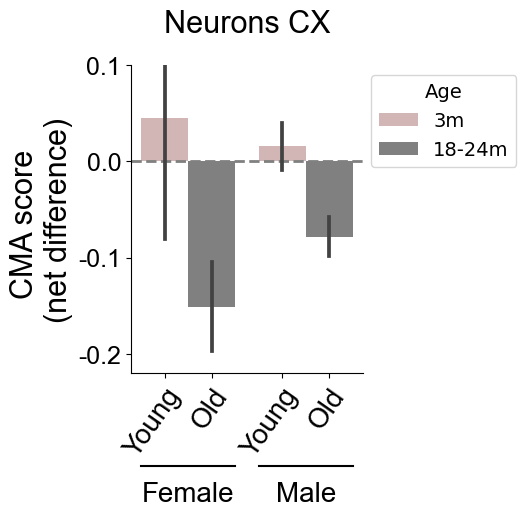

In [16]:
# Figure Neurons CX
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='celltype_ns', data=barcode[(barcode.cell_type=='neuron') & (barcode.subtissue=='Cortex') ], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.22, 0.10)
ax.set_yticks([-0.20, -0.10, 0.00, 0.10])
ax.set_yticklabels([-0.20, -0.10, 0.00, 0.10], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Neurons CX', fontdict={'family':'Arial', 'size': 22}, y=1.08)

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig(output_dir + '/Brain/Neur_cellns_sex_cx.png',bbox_inches='tight', dpi=300)

plt.show()

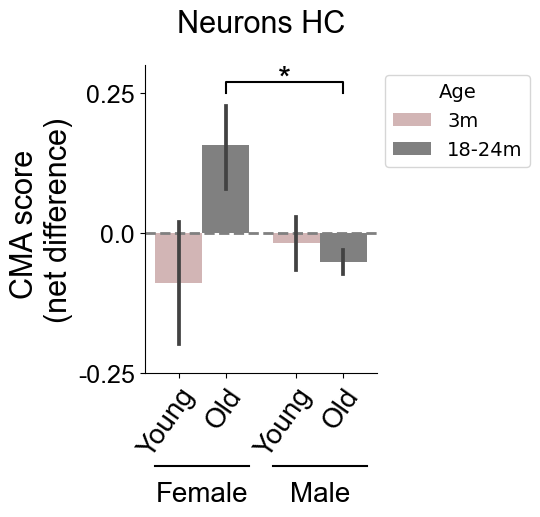

In [17]:
# Figure Neuron HC
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='celltype_ns', data=barcode[(barcode.cell_type=='neuron') & (barcode.subtissue=='Hippocampus') ], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.25, 0.30)
ax.set_yticks([-0.25, 0.00, 0.25])
ax.set_yticklabels([-0.25, 0.00, 0.25], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Neurons HC', fontdict={'family':'Arial', 'size': 22}, y=1.08)
 

# statistical annotation
x1, x2 = 0.2, 1.2   
y, h, col = 0.25 , 0.02, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-0.005, "*", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig(output_dir + '/Brain/Neur_cellns_sex_hc.png',bbox_inches='tight', dpi=300)

plt.show()

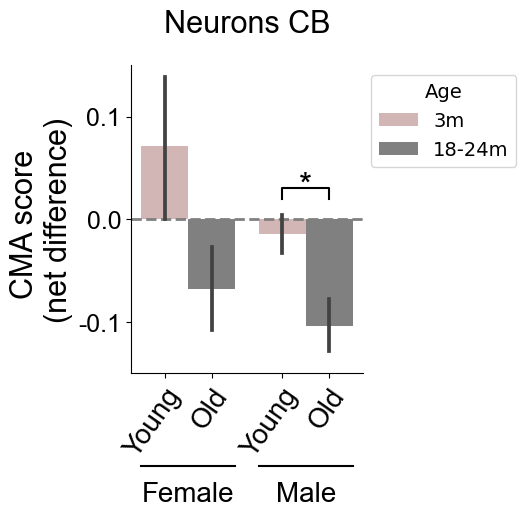

In [19]:
# Figure Neuron CB
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='celltype_ns', data=barcode[(barcode.cell_type=='neuron') & (barcode.subtissue=='Cerebellum') ], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.15, 0.15)
ax.set_yticks([-0.10, 0.0, 0.10])
ax.set_yticklabels([-0.10, 0.0, 0.10], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Neurons CB', fontdict={'family':'Arial', 'size': 22}, y=1.08)
 
# statistical annotation
x1, x2 = 0.8, 1.2   
y, h, col = 0.02 , 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-0.003, "*", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig(output_dir + '/Brain/Neur_cellns_sex_cb.png',bbox_inches='tight', dpi=300)

plt.show()

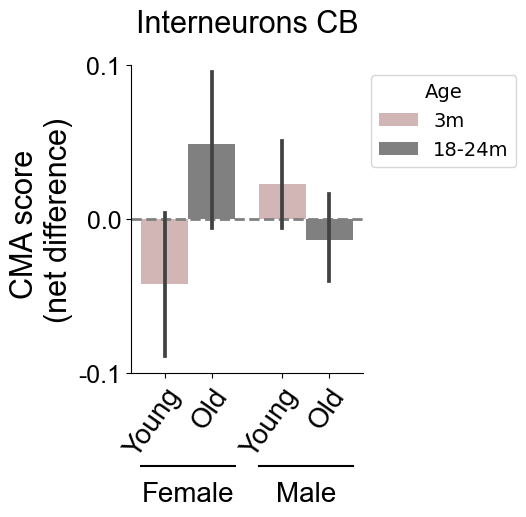

In [20]:
# Figure Interneuron CB
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='celltype_ns', data=barcode[(barcode.cell_type=='interneuron') & (barcode.subtissue=='Cerebellum') ], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.1, 0.1)
ax.set_yticks([-0.10, 0.0, 0.10])
ax.set_yticklabels([-0.10, 0.0, 0.10], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Interneurons CB', fontdict={'family':'Arial', 'size': 22}, y=1.08)
 
# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig(output_dir + '/Brain/Interneur_cellns_sex_cb.png',bbox_inches='tight', dpi=300)

plt.show()

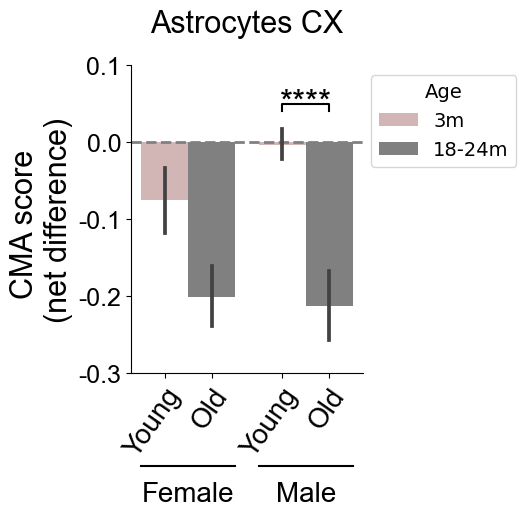

In [21]:
# Figure Astrocyte cx
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='celltype_ns', data=barcode[(barcode.cell_type=='astrocyte') & (barcode.subtissue=='Cortex') ], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.30, 0.10)
ax.set_yticks([-0.30, -0.20, -0.10, 0.00, 0.10])
ax.set_yticklabels([-0.30, -0.20, -0.10, 0.00, 0.10], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Astrocytes CX', fontdict={'family':'Arial', 'size': 22}, y=1.08)
 

# statistical annotation
x1, x2 = 0.8, 1.2   
y, h, col = 0.04 , 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-0.01, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig(output_dir + '/Brain/Ast_cellns_sex_cx.png',bbox_inches='tight', dpi=300)

plt.show()

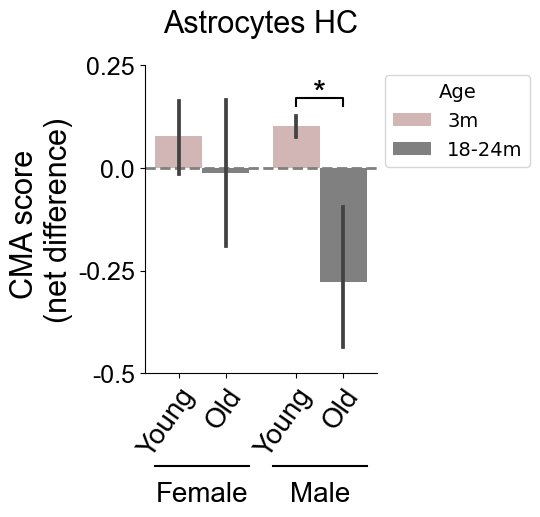

In [22]:
# Figure Astrocyte HC
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='celltype_ns', data=barcode[(barcode.cell_type=='astrocyte') & (barcode.subtissue=='Hippocampus') ], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.50, 0.25)
ax.set_yticks([-0.50, -0.25, 0.00, 0.25])
ax.set_yticklabels([-0.50, -0.25, 0.00, 0.25], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Astrocytes HC', fontdict={'family':'Arial', 'size': 22}, y=1.08)
 

# statistical annotation
x1, x2 = 0.8, 1.2   
y, h, col = 0.15 , 0.02, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-0.01, "*", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig(output_dir + '/Brain/Ast_cellns_sex_hc.png',bbox_inches='tight', dpi=300)

plt.show()

### Raw data (fold over cell types)

In [24]:
# Extracting raw values for bar graphs graphic
def raw (tipos, zona, edad, sex):
    long = []
    celula = []
    age = []
    mean=[]
    sem=[]
    sexo = []
    area = []
    for i in tipos:
        for a in zona:
            for x in edad:
                for y in sex:
                    n = len(barcode[barcode['cell_type']== i][barcode['subtissue']== a][barcode['new_age']== x]
                            [barcode['sex']== y].index)
                    m = np.mean(barcode[barcode['cell_type']== i][barcode['subtissue']== a][barcode['new_age']== x]
                                [barcode['sex']== y]['celltype_ns'])
                    s = stats.sem(barcode[barcode['cell_type']== i][barcode['subtissue']== a][barcode['new_age']== x]
                                  [barcode['sex']== y]['celltype_ns'])

                    long.append(n)
                    celula.append(i)                
                    age.append(x)
                    sexo.append(y)
                    mean.append(m)
                    sem.append(s)
                    area.append(a)
                    
    df_raw = pd.DataFrame({"Cell_type": celula, "Region":area, "Age": age, "Sex":sexo, "n": long, "Mean":mean, "SEM": sem})
    df_raw.to_excel(output_dir + "/Brain_nscRaw_data.xlsx")
    
    return(df_raw)

In [25]:
raw(tipos = cells, zona=areas, edad=['3m', '18-24m'], sex=['female', 'male'])

,Cell_type,Region,Age,Sex,n,Mean,SEM
0,neuron,Cortex,3m,female,4,0.045371,0.127237
1,neuron,Cortex,3m,male,38,0.015974,0.023677
2,neuron,Cortex,18-24m,female,29,-0.150718,0.045886
3,neuron,Cortex,18-24m,male,107,-0.078610,0.021161
4,neuron,Hippocampus,3m,female,4,-0.088948,0.106909
5,neuron,Hippocampus,3m,male,12,-0.017674,0.051466
6,neuron,Hippocampus,18-24m,female,8,0.157345,0.075198
7,neuron,Hippocampus,18-24m,male,71,-0.051308,0.023282
8,neuron,Cerebellum,3m,female,11,0.070814,0.069133
9,neuron,Cerebellum,3m,male,81,-0.014290,0.018373


## CMA network heatmaps by cell type & sex

In [26]:
# Load matrix reordered
model_matrix = pd.read_excel(modelmx, 'reordered')

# Removing EEF1A1 and RAC1 because they don't appear in the adata
model_matrix = model_matrix.drop([6, 8], axis=0).reset_index()

# Mapping data from adata to new order of CMA network
cma_network = adata[:, model_matrix["Ensembl_ms"]]

# GFAP does not appear in some cell types, creating a list without it
nogfap = ['LAMP2', 'HSPA8', 'HSP90AA1', 'HSP90AB1', 'DNAJB1', 'PHLPP1', 'NFATC1', 'NCOR1', 'NFE2L2', 'RAB11A', 
          'RICTOR', 'AKT1', 'AKT2', 'CTSA', 'RARA']

In [29]:
# Function for heatmaps
def sex_heatmaps(cellpop, region):
    
    # Prepare empty matrix
    matrix = np.zeros((16, 4))
    
    # Find cell indices for each condition
    female_3m = list(barcode[barcode['cell_type'] == cellpop][barcode['subtissue'] == region]
                     [barcode['sex'] == "female"][barcode['new_age'] == "3m"].index)
    female_18_24m = list(barcode[barcode['cell_type'] == cellpop][barcode['subtissue'] == region]
                         [barcode['sex'] == "female"][barcode['new_age'] == "18-24m"].index)
    male_3m = list(barcode[barcode['cell_type'] == cellpop][barcode['subtissue'] == region]
                   [barcode['sex'] == "male"][barcode['new_age'] == "3m"].index)
    male_18_24m = list(barcode[barcode['cell_type'] == cellpop][barcode['subtissue'] == region]
                       [barcode['sex'] == "male"][barcode['new_age'] == "18-24m"].index)
    
    # Calculate mean per gene for every condition
    for rank in tqdm(np.arange(matrix.shape[0])):    
        matrix[rank, 0] = np.mean(cma_network[female_3m, :].X.todense()[:, rank])
        matrix[rank, 1] = np.mean(cma_network[female_18_24m, :].X.todense()[:, rank])
        matrix[rank, 2] = np.mean(cma_network[male_3m, :].X.todense()[:, rank])
        matrix[rank, 3] = np.mean(cma_network[male_18_24m, :].X.todense()[:, rank])
            
    # Perform z-scoring on each row
    matrix_zs = matrix.copy()

    for i in np.arange(matrix_zs.shape[0]):
    
        µ = np.mean(matrix_zs[i, :])
        sd = np.std(matrix_zs[i, :])
    
        matrix_zs[i, :] = (matrix_zs[i, :] - µ) / sd        
    
    # Saving raw data
    df_m = pd.DataFrame(matrix_zs, columns=['female_young', 'female_old', 'male_young', 'male_old'], 
                        index=model_matrix['Gene name'])
    df_m.to_excel(output_dir + "/Brain/Heatmap.xlsx", sheet_name='{}_{}_heat'.format(cellpop, region), index=True)
    
    # Plot heatmap including all conditions and Removing NFATC1 in Astrocytes Cerebellum
    
    if cellpop == 'astrocyte' and region == 'Cerebellum':
        print("Moving to the next cell type and region")
        
    else:
        fig, ax = plt.subplots(figsize=(6,6))
        hfont = {'fontname':'Arial'}

        plt.imshow(matrix_zs, cmap='viridis', vmin=-1.5, vmax=1.5)
        plt.colorbar(shrink=.5).set_label(label="Gene Z score", size=16, **hfont)

        plt.yticks(np.arange(16), model_matrix['Gene name'], fontsize=16, **hfont)

        plt.ylim(15.5, -0.5)

        plt.xticks(np.arange(4), ['3m', '18-24m', '3m', '18-24m'], rotation=55, ha='right', rotation_mode='anchor',fontsize=16, **hfont)
        plt.title(cellpop.title()+' '+region.title(), fontdict={'family':'Arial', 'size': 22}, y=1.05)

        plt.axvline(x=1.5, linestyle='dashed', linewidth=2, color='k', zorder=1)

        # Annotations
        trans = ax.get_yaxis_transform()
        trans2 = ax.get_xaxis_transform()
        ax.annotate('Effectors', xy=(-1.5, 0), xycoords=trans, ha='left', rotation=90, va="top", 
                    color='k', size=16, **hfont)
        ax.plot([-1.25,-1.25],[-0.25, 4.25], color="k", transform=trans, clip_on=False)

        ax.annotate('Pos. regulators', xy=(-1.5, 4.75), xycoords=trans, ha='left', rotation=90, va="top", 
                    color='green', size=16, **hfont)
        ax.plot([-1.25,-1.25],[4.75, 10.25], color="k", transform=trans, clip_on=False)

        ax.annotate('Neg. regulators', xy=(-1.5, 10.5), xycoords=trans, ha='left', rotation=90, va="top", 
                    color='red', size=16, **hfont)
        ax.plot([-1.25,-1.25],[11, 15.25], color="k", transform=trans, clip_on=False)

        ax.annotate('Female', xy=(0.4, -.22), xycoords=trans2, ha="center", va="top", size=16, **hfont)
        ax.plot([-.5,1.25],[-.2,-.2], color="k", transform=trans2, clip_on=False)

        ax.annotate('Male', xy=(2.6, -.22), xycoords=trans2, ha="center", va="top", size=16, **hfont)
        ax.plot([1.5, 3.25],[-.2,-.2], color="k", transform=trans2, clip_on=False)

    plt.savefig(output_dir + '/Brain/{}_sex_{}_heat.png'.format(cellpop,region),bbox_inches='tight', dpi=300)
    plt.show()

100%|██████████| 16/16 [00:00<00:00, 54.37it/s]


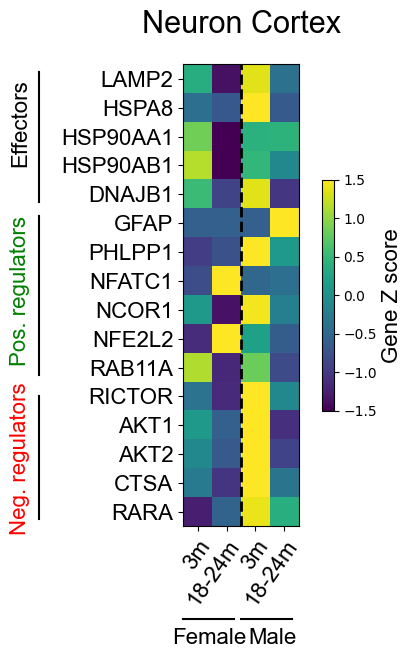

100%|██████████| 16/16 [00:00<00:00, 61.34it/s]


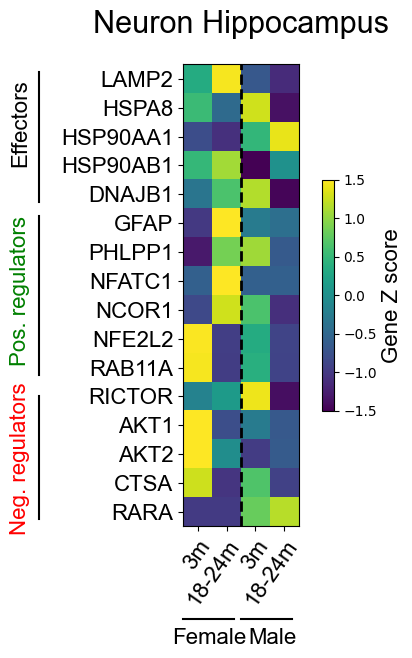

100%|██████████| 16/16 [00:00<00:00, 58.07it/s]


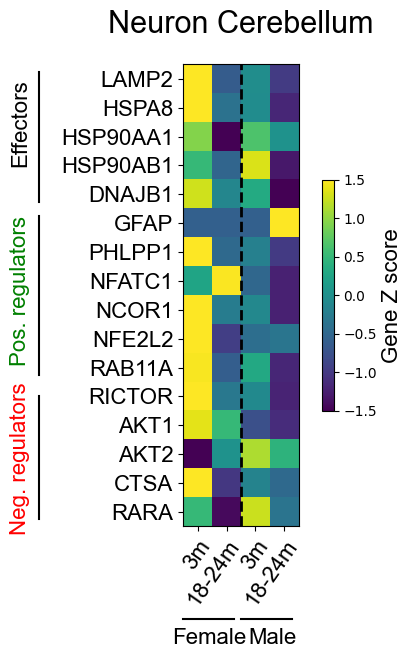

100%|██████████| 16/16 [00:00<00:00, 48.90it/s]


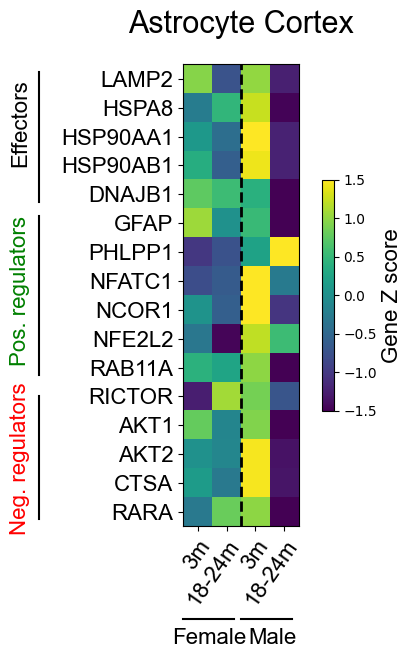

100%|██████████| 16/16 [00:00<00:00, 55.53it/s]


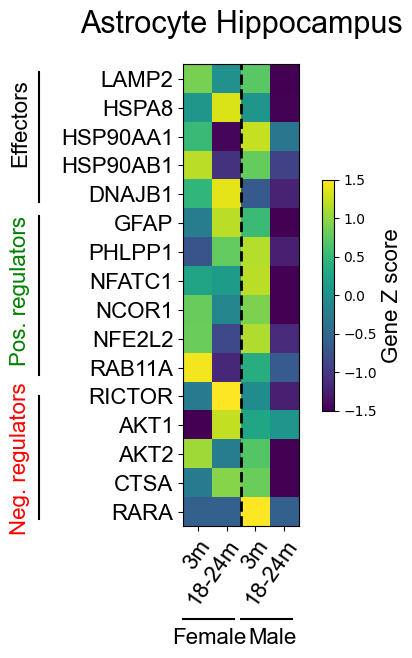

100%|██████████| 16/16 [00:00<00:00, 59.56it/s]

Moving to the next cell type and region


In [30]:
# Creating heatmaps
for i in ['neuron', 'astrocyte']:
    for j in areas:
        sex_heatmaps(cellpop=i, region=j)

100%|██████████| 16/16 [00:00<00:00, 60.54it/s]


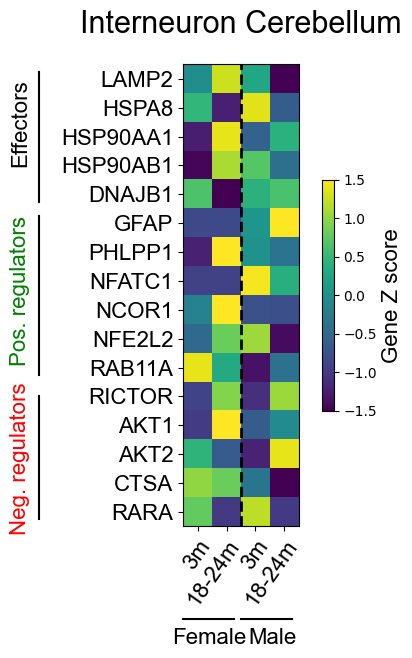

In [31]:
sex_heatmaps(cellpop='interneuron', region='Cerebellum')